# Import libraries and dataset

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# import data
data = pd.read_excel("/content/export_User_Comments_Polarity_Category_clean.xlsx")
data.head()

,Polarity,UserComments,Polarity_type
0,0.0,bought projector clueless connect iphon,Negative
1,0.0,promis multi card reader leav review im still ...,Negative
2,0.0,hello apeman team respond email fix issu multi...,Negative
3,0.8,great pictur excit look k camerajust need pric...,Positive
4,0.0,bought apeman dashcam find rear camer cabl met...,Negative


In [3]:
# drop Polarity column
data.drop('Polarity', inplace=True, axis=1)

# Preprocessing

In [4]:
# identify null
data.isna().sum()

UserComments     0
Polarity_type    0
dtype: int64

In [5]:
# drop null
data = data.dropna()

In [6]:
data.head()

,UserComments,Polarity_type
0,bought projector clueless connect iphon,Negative
1,promis multi card reader leav review im still ...,Negative
2,hello apeman team respond email fix issu multi...,Negative
3,great pictur excit look k camerajust need pric...,Positive
4,bought apeman dashcam find rear camer cabl met...,Negative


In [7]:
# export to Excel
from pandas import ExcelWriter
writer = ExcelWriter('User_Comments_Category.xlsx')
data.to_excel(writer,'Sheet1',index=False)
writer.save()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


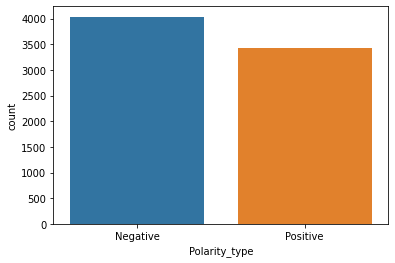

In [8]:
# checking the class distribution
sns.countplot(data['Polarity_type'])

In [9]:
# importing the NLP libraries
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
import re,string,unicodedata
from bs4 import BeautifulSoup
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
stop = set(stopwords.words('english'))
punctuation=list(string.punctuation)
stop.update(punctuation)

# Data cleaning

In [11]:
def html_strip(text):
    soup = BeautifulSoup(text,"html.parser")
    return soup.get_text()

def remove_square_bracs(text):
    return re.sub('\[[^]]*\]','',text)

def remove_urls(text):
    return re.sub(r'http\S+','',text)

def remove_stopwords(text):
    final_txt=[]
    for i in text.split():
        if i.strip().lower() not in stop:
            final_txt.append(i.strip())
    return " ".join(final_txt)

def remove_noisy_data(text):
    txt = html_strip(text)
    txt = remove_square_bracs(text)
    txt = remove_urls(text)
    txt = remove_stopwords(text)
    return text

In [12]:
data['UserComments']=data['UserComments'].apply(remove_noisy_data)

In [13]:
data.head()

,UserComments,Polarity_type
0,bought projector clueless connect iphon,Negative
1,promis multi card reader leav review im still ...,Negative
2,hello apeman team respond email fix issu multi...,Negative
3,great pictur excit look k camerajust need pric...,Positive
4,bought apeman dashcam find rear camer cabl met...,Negative


# Label encoder

In [14]:
from sklearn import preprocessing
# label_encoder object knows how to understand word labels
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'Polarity_type'
data['Polarity_type']= label_encoder.fit_transform(data['Polarity_type'])
print(data.head())

                                        UserComments  Polarity_type
0            bought projector clueless connect iphon              0
1  promis multi card reader leav review im still ...              0
2  hello apeman team respond email fix issu multi...              0
3  great pictur excit look k camerajust need pric...              1
4  bought apeman dashcam find rear camer cabl met...              0


# Converting text into accetable format

In [15]:
words = []
for i in data.UserComments.values:
    words.append(i.split())

words[:3]

[['bought', 'projector', 'clueless', 'connect', 'iphon'],
 ['promis',
  'multi',
  'card',
  'reader',
  'leav',
  'review',
  'im',
  'still',
  'wait',
  'susi'],
 ['hello',
  'apeman',
  'team',
  'respond',
  'email',
  'fix',
  'issu',
  'multipl',
  'follow',
  'up']]

In [16]:
import gensim

embed_dim = 200

word2vec_model = gensim.models.Word2Vec(sentences = words,size = embed_dim,window=5, min_count=1)

In [17]:
len(word2vec_model.wv.vocab)

11974

# Tokenizing

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer= Tokenizer(num_words = 35000)
tokenizer.fit_on_texts(words)
tokenized_sequences = tokenizer.texts_to_sequences(words)
x = pad_sequences(tokenized_sequences,maxlen=20)

In [19]:
x.shape

(7471, 20)

In [20]:
vocab_size = len(tokenizer.word_index)+ 1

# Funtion to create weight matrix

In [21]:
def weight_matrix(model,vocab):
    vocab_size= len(vocab)+1
    wgt_matrix = np.zeros((vocab_size,embed_dim))
    for word, i in vocab.items():
        wgt_matrix[i]=model[word]
    return wgt_matrix

In [22]:
embedding_vec = weight_matrix(word2vec_model,tokenizer.word_index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


# Model training

In [23]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional,LSTM,GRU,Dense

In [24]:
model =Sequential([
    Embedding(vocab_size, output_dim = embed_dim,weights=[embedding_vec],input_length =20,trainable=True),
    Bidirectional(LSTM(128, recurrent_dropout=0.1, dropout=0.3, return_sequences=True)),
    Bidirectional(GRU(32, recurrent_dropout=0.1,dropout=0.1)),
    Dense(1,activation='sigmoid')
])

In [25]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer = Adam(lr=0.01),loss='binary_crossentropy', metrics =['acc'])

del embedding_vec

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 200)           2395000   
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 256)           336896    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                55680     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 2,787,641
Trainable params: 2,787,641
Non-trainable params: 0
_________________________________________________________________


In [27]:
from sklearn.model_selection import train_test_split

trainX,testX,trainY,testY = train_test_split(x,data.Polarity_type,test_size=0.25,random_state=0)

In [28]:
hist = model.fit(trainX,trainY,batch_size=500, validation_data =(testX,testY))
#hist_train = model.fit(trainX,trainY)

12/12 [==============================] - 15s 1s/step - loss: 0.7889 - acc: 0.5074 - val_loss: 0.6809 - val_acc: 0.5685


# Model analysis

In [29]:
pred = model.predict_classes(testX)
pred[:5]

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[0],
       [0],
       [0],
       [1],
       [1]], dtype=int32)

In [30]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(testY,pred)
cm

array([[687, 335],
       [471, 375]])

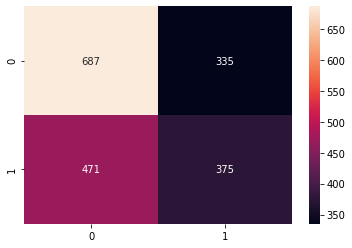

In [31]:
sns.heatmap(cm,annot=True,fmt='g')

In [32]:
from sklearn.metrics import classification_report

print(classification_report(testY,pred,target_names = ['Negative', 'Positive' ]))

              precision    recall  f1-score   support

    Negative       0.59      0.67      0.63      1022
    Positive       0.53      0.44      0.48       846

    accuracy                           0.57      1868
   macro avg       0.56      0.56      0.56      1868
weighted avg       0.56      0.57      0.56      1868



Ref: https://www.kaggle.com/maheer/sarcasm-detection-tensorflow-keras-word2vec/comments